🔍 Starting Multimodal Similarity Search...
📊 Collection: multimodal_embeddings
🖼️ Query Images: C:\Users\Arman\OneDrive\Desktop\sss\ADSDB\pr\WildLife\notebook\Multi-Modal Tasks\./query_images
🔗 Connecting to MinIO...
✅ Connected to MinIO - Bucket 'trusted-zone' verified
🗄️ Connecting to ChromaDB...
✅ Connected to collection: multimodal_embeddings
📊 Collection contains 12196 items
🖼️ Found 4 query images: ['Anilius_Scytale.jpg', 'Anilius_Scytale_2.jpg', 'Squamata Pythonidae_imbricata.webp']...
📊 Found 6098 image files in bucket
✅ Helper functions defined
🚀 Starting Multimodal Wildlife Search...

🎯 MULTIMODAL WILDLIFE SEARCH
Instructions:
• Enter any text to search for similar wildlife
• Enter 'image' to search using a random image
• Enter 'quit' to exit



🔍 Enter your search query (or 'image'/'quit'):  python



🔍 Searching with text: 'python'

🔍 TEXT QUERY RESULTS
Query: 'python'
📊 Found 5 similar items:
------------------------------------------------------------

RESULT #1 - molurus
Species: molurus
Scientific Name: Python molurus
Common Name: Unknown
Kingdom: Animalia
Phylum: Chordata
Class: Squamata
Order: nan
Family: Pythonidae
Genus: Python
Similarity: 0.734

Description:
This life is commonly known as Indian rock python scientifically named as Python molurus in kingdom Animalia phylum Chordata in the Squamata class belonging to the Pythonidae family genus Python and species of molurus.

------------------------------------------------------------


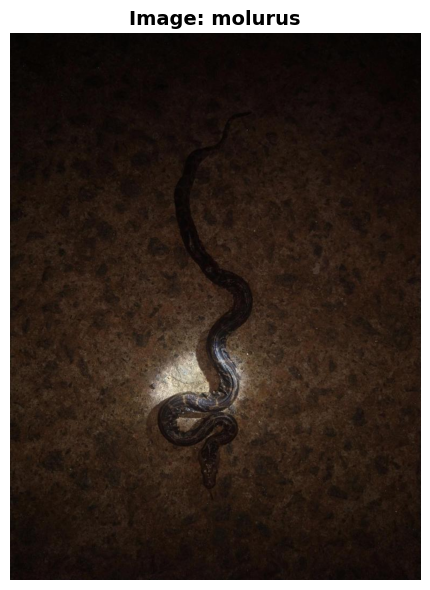

✅ Displayed result 1/5: molurus


RESULT #2 - molurus
Species: molurus
Scientific Name: Python molurus
Common Name: Unknown
Kingdom: Animalia
Phylum: Chordata
Class: Squamata
Order: nan
Family: Pythonidae
Genus: Python
Similarity: 0.734

Description:
This life is commonly known as Indian rock python scientifically named as Python molurus in kingdom Animalia phylum Chordata in the Squamata class belonging to the Pythonidae family genus Python and species of molurus.

------------------------------------------------------------


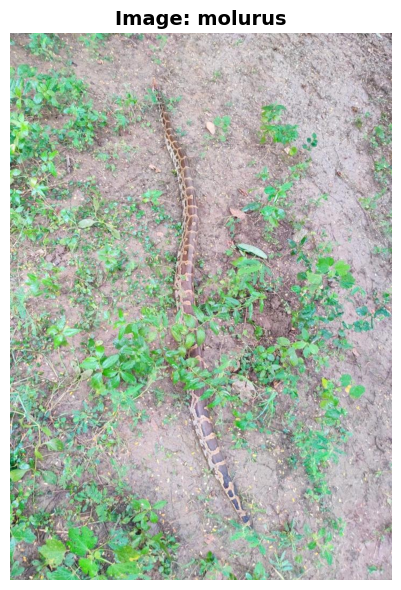

✅ Displayed result 2/5: molurus


RESULT #3 - molurus
Species: molurus
Scientific Name: Python molurus
Common Name: Unknown
Kingdom: Animalia
Phylum: Chordata
Class: Squamata
Order: nan
Family: Pythonidae
Genus: Python
Similarity: 0.734

Description:
This life is commonly known as Indian rock python scientifically named as Python molurus in kingdom Animalia phylum Chordata in the Squamata class belonging to the Pythonidae family genus Python and species of molurus.

------------------------------------------------------------


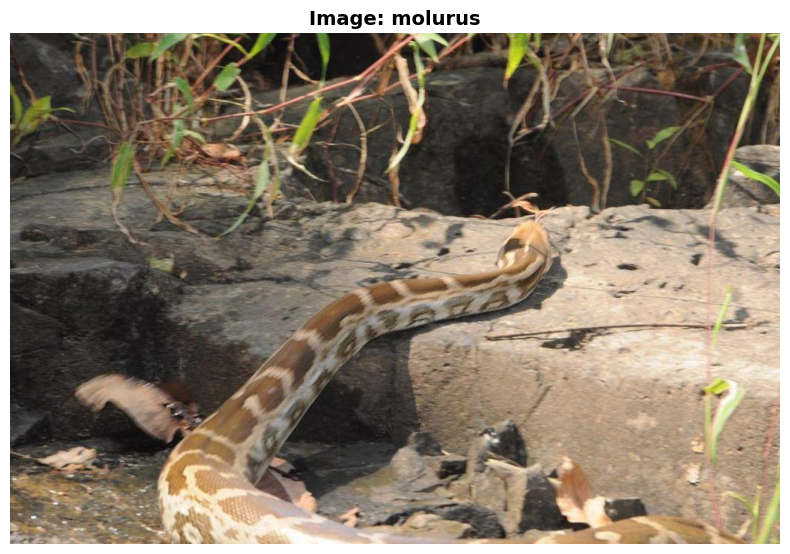

✅ Displayed result 3/5: molurus


RESULT #4 - molurus
Species: molurus
Scientific Name: Python molurus
Common Name: Unknown
Kingdom: Animalia
Phylum: Chordata
Class: Squamata
Order: nan
Family: Pythonidae
Genus: Python
Similarity: 0.734

Description:
This life is commonly known as Indian rock python scientifically named as Python molurus in kingdom Animalia phylum Chordata in the Squamata class belonging to the Pythonidae family genus Python and species of molurus.

------------------------------------------------------------


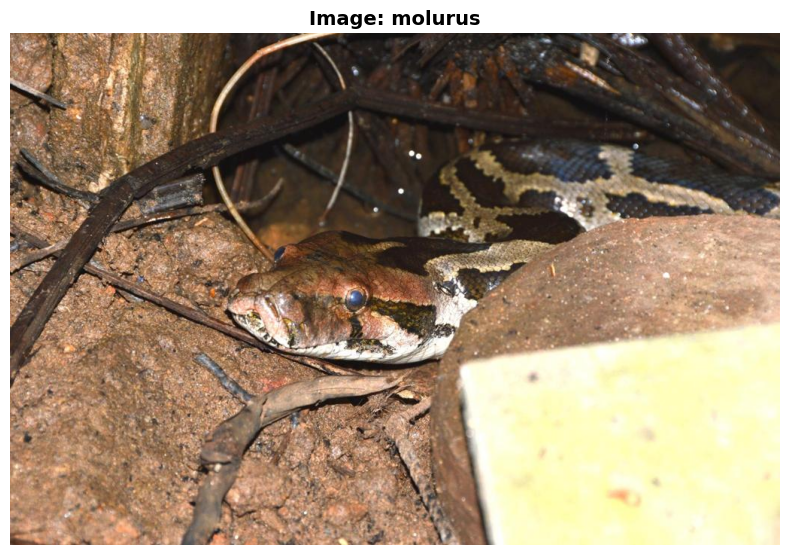

✅ Displayed result 4/5: molurus


RESULT #5 - molurus
Species: molurus
Scientific Name: Python molurus
Common Name: Unknown
Kingdom: Animalia
Phylum: Chordata
Class: Squamata
Order: nan
Family: Pythonidae
Genus: Python
Similarity: 0.734

Description:
This life is commonly known as Indian rock python scientifically named as Python molurus in kingdom Animalia phylum Chordata in the Squamata class belonging to the Pythonidae family genus Python and species of molurus.

------------------------------------------------------------


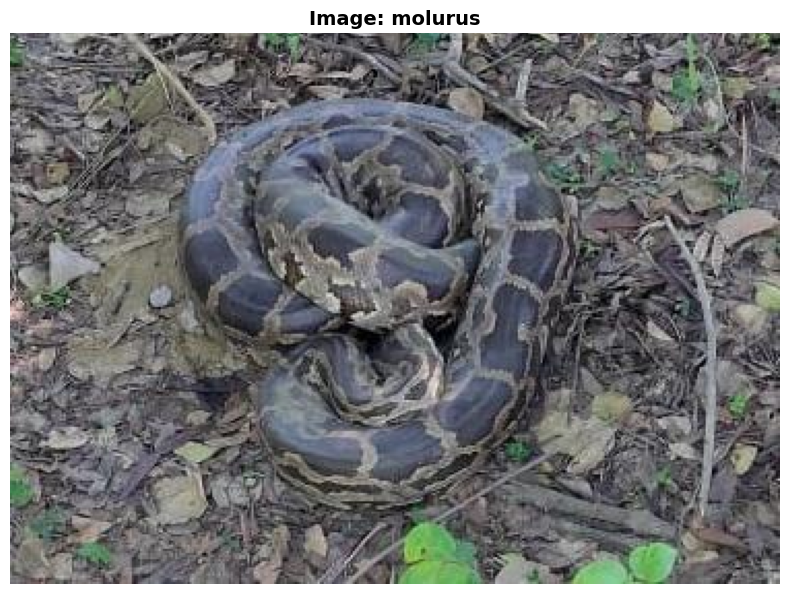

✅ Displayed result 5/5: molurus


👋 Goodbye!

📊 COLLECTION STATISTICS



KeyboardInterrupt



In [3]:
"""
-Arman Bazarchi-
Multimodal Similarity Search Task

Performs similarity searches using both text and image queries
Returns mixed results with both images and text descriptions

- Connects to a ChromaDB multimodal collection where text and image embeddings are stored.
- Supports text-based queries to retrieve similar items with both descriptions and images.
- Supports image-based queries to retrieve similar items with both descriptions and images.
- Returns results enriched with enough details (species, scientific name, kingdom, class, family, etc.).
- Displays results with images and textual description.
- Displays basic collection statistics (total items, distribution by kingdom, class, and family).
- Users cannot query with both text and image at same time here, queries are performed one modality at a time.


"""

import chromadb
from chromadb.utils import embedding_functions
import pandas as pd
import io
import os
import random
from minio import Minio
import sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# ==============================
#          Functions
# ==============================

def setup_minio_connection(minio_endpoint, access_key, secret_key, trusted_bucket):
    # Setup and verify MinIO client connection.
    print(" Connecting to MinIO...")
    client = Minio(
        minio_endpoint,
        access_key=access_key,
        secret_key=secret_key,
        secure=False
    )
    
    # Verify trusted-zone bucket exists
    if not client.bucket_exists(trusted_bucket):
        sys.exit(f" ERROR: Bucket '{trusted_bucket}' does not exist in MinIO.")
    
    print(f" Connected to MinIO - Bucket '{trusted_bucket}' verified")
    return client

def setup_chromadb_connection(chroma_db_path, collection_name):
    # Setup ChromaDB client and collection.
    
    print(" Connecting to ChromaDB...")
    chroma_client = chromadb.PersistentClient(path=chroma_db_path)
    
    # Get the multimodal collection
    try:
        collection = chroma_client.get_collection(name=collection_name)
        print(f" Connected to collection: {collection_name}")
        
        # Get collection info
        collection_count = collection.count()
        print(f" Collection contains {collection_count} items")
        
        return collection
    except Exception as e:
        sys.exit(f" ERROR: Could not connect to collection '{collection_name}' → {e}")

def setup_query_images(query_images_path):
    # Setup and verify query images directory.
    
    if not os.path.exists(query_images_path):
        sys.exit(f" ERROR: Query images directory '{query_images_path}' does not exist.")
    
    query_images = [f for f in os.listdir(query_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]
    print(f" Found {len(query_images)} query images: {query_images[:3]}...")
    return query_images

def preload_image_paths(client, trusted_bucket):
    # Pre-load image paths for efficient lookup.
    
    all_image_objects = list(client.list_objects(trusted_bucket, prefix="images/", recursive=True))
    image_paths = {obj.object_name.split('/')[-1].replace('.jpg', ''): obj.object_name 
                   for obj in all_image_objects if obj.object_name.endswith('.jpg')}
    print(f" Found {len(image_paths)} image files in bucket")
    return image_paths

def load_image_from_minio(client, trusted_bucket, image_paths, uuid):
    # Load image from MinIO using pre-loaded path dictionary.
    try:
        # Get image path
        image_path = image_paths.get(uuid)
        if not image_path:
            print(f" Image not found for UUID: {uuid}")
            return None
            
        image_data = client.get_object(trusted_bucket, image_path)
        image_bytes = image_data.read()
        image_data.close()
        image_data.release_conn()
        
        image = Image.open(io.BytesIO(image_bytes))
        return image
    except Exception as e:
        print(f" Could not load image {uuid}: {e}")
        return None

def get_random_query_image(query_images, query_images_path):
    # Get a random image from the query_images directory. for performing images tasks.
    if not query_images:
        return None, None
    # selecting a random image
    random_image = random.choice(query_images)
    image_path = os.path.join(query_images_path, random_image)
    
    try:
        image = Image.open(image_path)
        print(f" Selected random query image: {random_image}")
        return image, random_image
    except Exception as e:
        print(f" Error loading image {random_image}: {e}")
        return None, None

def prepare_result_data(ids, distances, metadatas, documents, collection, client, trusted_bucket, image_paths):
    # Prepare result data for display.
    result_data = []
    for i, (item_id, distance, metadata, document) in enumerate(zip(ids, distances, metadatas, documents)):
        # as in multimodal embeddings we are storing with a _txt or _img in end.
        uuid = item_id.replace('_img', '').replace('_txt', '')
        
        # Load image (defined the function in lower part)
        image = load_image_from_minio(client, trusted_bucket, image_paths, uuid)
        
        # Load text description
        text_description = get_text_description(collection, uuid, document)
        
        # appending needed data
        result_data.append({
            'index': i + 1,
            'similarity': 1 - distance,
            'image': image,
            'description': text_description,
            'metadata': metadata,
            'common_name': metadata.get('common', 'Unknown'),
            'scientific_name': metadata.get('scientific_name', 'Unknown'),
            'species': metadata.get('species', 'Unknown'),
            'kingdom': metadata.get('kingdom', 'N/A'),
            'class': metadata.get('class', 'N/A'),
            'family': metadata.get('family', 'N/A'),
            'genus': metadata.get('genus', 'N/A'),
            'order': metadata.get('order', 'N/A'),
            'phylum': metadata.get('phylum', 'N/A')
        })
    return result_data

def get_text_description(collection, uuid, document):
    # Get text description for a result.
    
    text_description = ""
    try:
        # get only text using modality as text
        text_results = collection.get(
            where={"$and": [{"uuid": uuid}, {"modality": "text"}]})

        # get documents
        if text_results['documents'] and len(text_results['documents']) > 0:
            text_description = text_results['documents'][0]
        elif document and document != "None":
            text_description = document
    except Exception:
        if document and document != "None":
            text_description = document
    return text_description

def display_result_items(result_data):
    # Display individual result items.
    
    for i, data in enumerate(result_data):
        print(f"\n{'='*80}")
        print(f"RESULT #{data['index']} - {data['species']}")
        print(f"{'='*80}")
        
        # Print details 
        print(f"Species: {data['species']}")
        print(f"Scientific Name: {data['scientific_name']}")
        print(f"Common Name: {data['common_name']}")
        print(f"Kingdom: {data['kingdom']}")
        print(f"Phylum: {data['phylum']}")
        print(f"Class: {data['class']}")
        print(f"Order: {data['order']}")
        print(f"Family: {data['family']}")
        print(f"Genus: {data['genus']}")
        print(f"Similarity: {data['similarity']:.3f}")
        
        # Add description if available
        if data['description']:
            desc = data['description']
            print(f"\nDescription:\n{desc}")
        else:
            print("\nDescription: No description available")
        
        print(f"\n{'-'*60}")
        
        # Then show the image
        if data['image']:
            _, ax = plt.subplots(1, 1, figsize=(8, 6))
            ax.imshow(data['image'])
            ax.set_title(f"Image: {data['species']}", fontsize=14, fontweight='bold')
            ax.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print(f" Image not available for {data['species']}")
        
        print(f" Displayed result {i+1}/{len(result_data)}: {data['species']}")
        print(f"{'='*80}\n")

def display_results(results, query_type="text", query_value="", n_results=5, is_cluster_search=False, 
                   collection=None, client=None, trusted_bucket=None, image_paths=None):
    # Display search results with images and descriptions.
    
    print(f"\n🔍 {query_type.upper()} QUERY RESULTS")
    print(f"Query: '{query_value}'")
    # if we are displayin results of a cluster search
    if is_cluster_search:
        print(" Cluster-based search (top 3 most frequent species)")
    print("=" * 60)

    # if no results
    if not results['ids'] or len(results['ids'][0]) == 0:
        print(" No results found!")
        return
        
    # get id and other data from each result
    ids = results['ids'][0][:n_results]
    distances = results['distances'][0][:n_results]
    metadatas = results['metadatas'][0][:n_results]
    documents = results['documents'][0][:n_results] if 'documents' in results else [None] * len(ids)
    
    print(f"Found {len(ids)} similar items:")
    print("-" * 60)
    
    # Prepare data for all results first
    result_data = prepare_result_data(ids, distances, metadatas, documents, collection, client, trusted_bucket, image_paths)
    
    # Display results in simple format (description first, then image)
    display_result_items(result_data)

def cluster_based_search(collection, chroma_client, query_text="", query_image=None, n_results=15, return_count=3):
    # Perform cluster-based search showing top species representatives.
    print("\n CLUSTER-BASED SEARCH")
    print(f"Analyzing top-{n_results} results for most frequent species...")
    print("=" * 60)
    
    try:
        # so that when entered 'image' it should not take also '' empty text to do an extra text query
        if query_text and query_text.strip() != "":
            results = collection.query(
                query_texts=[query_text],
                n_results=n_results)
            
            print(f" Text cluster search: '{query_text}'")
        elif query_image is not None:
            results = perform_image_cluster_search(collection, chroma_client, query_image, n_results)
            if results is None:
                return None
        else:
            # if on query available
            print(" No query provided!")
            return None
        
        if not results['ids'] or len(results['ids'][0]) == 0:
            print(" No results found!")
            return None
        
        print(f"\n Analyzing {len(results['ids'][0])} similar items for species frequency...\n")
        
        # Extract species from enriched metadata
        species_list = []
        for metadata in results['metadatas'][0]:
            # Use the enriched metadata 
            species = metadata.get('species', 'Unknown')
            species_list.append(species)
        
        # Count frequency of species
        from collections import Counter
        species_counts = Counter(species_list)
        print("\n Species frequency analysis:")
        for species, count in species_counts.most_common():
            print(f"  {species}: {count} occurrences")
        
        # Get top 3 most frequent species
        top_species = [species for species, _ in species_counts.most_common(return_count)]
        print(f"\n Top {return_count} most frequent species: {top_species}")
        
        # Filter results to show exactly one representative from each top species
        filtered_results = filter_results_by_top_species(results, top_species, return_count)
        
        print("\n Species cluster analysis complete!")
        print(f" Original results: {len(results['ids'][0])}")
        print(f" Top species representatives: {len(filtered_results['ids'][0])}")
        print(f" Species represented: {set([meta.get('species', 'Unknown') for meta in filtered_results['metadatas'][0]])}")
        
        return filtered_results
        
    except Exception as e:
        print(f" Error during cluster-based search: {e}")
        return None

def perform_image_cluster_search(collection, chroma_client, query_image, n_results):
    # Perform image-based cluster search using embeddings.
    try:
        # Get the multimodal collection
        multimodal_collection = chroma_client.get_collection(name="multimodal_embeddings")
        
        # Generate embedding for the query image using OpenCLIP
        from langchain_experimental.open_clip import OpenCLIPEmbeddings
        clip_embd = OpenCLIPEmbeddings(
            model_name="ViT-B-32",
            checkpoint="laion2b_s34b_b79k"
        )
        
        # check and Convert to embeddable format, handling different types.
        query_embedding = generate_image_embedding(clip_embd, query_image)
        
        # Query the collection
        results = multimodal_collection.query(
            query_embeddings=[query_embedding],
            n_results=n_results
        )
        print(" Image cluster search (using image embeddings)")
        return results
        
    except Exception as e:
        print(f" Could not perform image search: {e}")
        return None

def generate_image_embedding(clip_embd, query_image):
    # Generate embedding for different image formats.
    if isinstance(query_image, Image.Image):
        # Save PIL image temporarily
        import tempfile
        with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as tmp_file:
            query_image.save(tmp_file.name)
            query_embedding = clip_embd.embed_image([tmp_file.name])[0]
        os.unlink(tmp_file.name)
    elif isinstance(query_image, np.ndarray):
        # Convert NumPy array to PIL first
        img = Image.fromarray(query_image.astype('uint8'), 'RGB')
        import tempfile
        with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as tmp_file:
            img.save(tmp_file.name)
            query_embedding = clip_embd.embed_image([tmp_file.name])[0]
        os.unlink(tmp_file.name)
    elif isinstance(query_image, str) and os.path.exists(query_image):
        # If a file path then embedd directly
        query_embedding = clip_embd.embed_image([query_image])[0]
    else:
        raise ValueError("Unsupported image format for embedding generation.")
    
    return query_embedding

def filter_results_by_top_species(results, top_species, return_count):
    # Filter results to show one representative from each top species.
    filtered_ids = []
    filtered_distances = []
    filtered_metadatas = []
    species_found = set()  # Track which species we've already included
    
    for i, (item_id, distance, metadata) in enumerate(zip(
        results['ids'][0], results['distances'][0], 
        results['metadatas'][0]
    )):
        # Use the enriched metadata field again
        species = metadata.get('species', 'Unknown')
        # Only add if this species is in top 3 and we haven't included it yet
        if species in top_species and species not in species_found:
            filtered_ids.append(item_id)
            filtered_distances.append(distance)
            filtered_metadatas.append(metadata)
            species_found.add(species)
            
            # Stop when we have one representative from each of the top 3 species
            if len(species_found) >= return_count:
                break
    
    # Create filtered results
    filtered_results = {
        'ids': [filtered_ids],
        'distances': [filtered_distances],
        'metadatas': [filtered_metadatas]
    }
    
    return filtered_results
    
# search functions
def search_by_text(collection, query_text, n_results=5, client=None, trusted_bucket=None, image_paths=None):
     # erform text-based similarity search.
    print(f"\n Searching with text: '{query_text}'")
    
    try:
        # query text
        results = collection.query(
            query_texts=[query_text],
            n_results=n_results)
        
        display_results(results, query_type="text", query_value=query_text, n_results=n_results, 
                       is_cluster_search=False, collection=collection, client=client, 
                       trusted_bucket=trusted_bucket, image_paths=image_paths)
        return results
        
    except Exception as e:
        print(f" Error during text search: {e}")
        return None

def search_by_image(collection, chroma_client, query_image, image_name="", 
                   client=None, trusted_bucket=None, image_paths=None):
    # Perform image-based similarity search using cluster-based approach.
    print(f"\n Searching with image: '{image_name}'")
    
    # Display the query image in smaller size and centered
    try:
        if isinstance(query_image, Image.Image):
            # Create a smaller, centered view
            _, ax = plt.subplots(1, 1, figsize=(4, 3))
            ax.imshow(query_image)
            ax.set_title(f"Query Image: {image_name}", fontsize=11, fontweight='bold')
            ax.axis('off')
            # Center the figure
            plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
            plt.show()
            print(f" Query image displayed: {image_name}")
        
        # Use cluster-based search for images 
        results = cluster_based_search(collection, chroma_client, query_image=query_image, n_results=15, return_count=3)
        
        if results:
            display_results(results, query_type="image", query_value=image_name, n_results=3, 
                           is_cluster_search=True, collection=collection, client=client, 
                           trusted_bucket=trusted_bucket, image_paths=image_paths)
        else:
            print(" No cluster results found!")
        
        return results
        
    except Exception as e:
        print(f" Error during image search: {e}")
        return None

def interactive_search(collection, chroma_client, query_images, query_images_path, 
                      client, trusted_bucket, image_paths):
    # Interactive search interface for user input
    print("\n MULTIMODAL WILDLIFE SEARCH")
    print("=" * 60)
    print("Instructions:")
    print("• Enter any text to search for similar wildlife")
    print("• Enter 'image' to search using a random image")
    print("• Enter 'quit' to exit")
    print("=" * 60)
    
    while True:
        try:
            user_input = input("\n Enter your search query (or 'image'/'quit'): ").strip()
            
            if user_input.lower() == 'quit':
                print(" Goodbye!")
                break
                
            elif user_input.lower() == 'image':
                # Random image search with cluster approach
                query_image, image_name = get_random_query_image(query_images, query_images_path)
                if query_image:
                    search_by_image(collection, chroma_client, query_image, image_name,
                                  client=client, trusted_bucket=trusted_bucket, image_paths=image_paths)
                else:
                    print(" No query images available!")
                    
            elif user_input:
                # Text-based search 
                search_by_text(collection, user_input, n_results=5, client=client, 
                              trusted_bucket=trusted_bucket, image_paths=image_paths)
                
            else:
                print(" Please enter a search query, 'image', or 'quit'")
                
        except KeyboardInterrupt:
            print("\n Goodbye!")
            break
        except Exception as e:
            print(f" Error: {e}")

def get_collection_statistics(collection):
    # Get statistics about the multimodal_embedding collection.
    print("\n COLLECTION STATISTICS")
    print("=" * 60)
    
    try:
        # Get all data
        all_data = collection.get()
        
        if all_data['ids']:
            print(f" Total items: {len(all_data['ids'])}")
            
            # Count by kingdom
            kingdoms = {}
            classes = {}
            families = {}
            
            for metadata in all_data['metadatas']:
                kingdom = metadata.get('kingdom', 'Unknown')
                cls = metadata.get('class', 'Unknown')
                family = metadata.get('family', 'Unknown')
                
                kingdoms[kingdom] = kingdoms.get(kingdom, 0) + 1
                classes[cls] = classes.get(cls, 0) + 1
                families[family] = families.get(family, 0) + 1
            
            print("\n By Kingdom:")
            for kingdom, count in sorted(kingdoms.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {kingdom}: {count}")
                
            print("\n By Class:")
            for cls, count in sorted(classes.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {cls}: {count}")
                
            print("\n Top Families:")
            for family, count in sorted(families.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {family}: {count}")
                
        else:
            print(" Collection is empty!")
            
    except Exception as e:
        print(f" Error getting statistics: {e}")

# ==============================
#        Main Function
# ==============================
def process_multimodal_task(
    minio_endpoint = "localhost:9000",
    access_key = "admin",
    secret_key = "password123"):
    # Configuration
    trusted_bucket = "trusted-zone"
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__)) # in orchestrated
    except NameError:
        script_dir = os.getcwd() # in notebook
        
    chroma_db = os.path.join(script_dir, "../../Exploitation-Zone/exploitation_db")
    query_images_path = os.path.join(script_dir, "../query_images")
    collection_name = "multimodal_embeddings"
    
    print(" Starting Multimodal Similarity Search...")
    print(f" Collection: {collection_name}")
    print(f" Query Images: {query_images_path}")
    print("=" * 60)
    
    # Setup connections
    client = setup_minio_connection(minio_endpoint, access_key, secret_key, trusted_bucket)
    collection = setup_chromadb_connection(chroma_db, collection_name)
    query_images = setup_query_images(query_images_path)
    image_paths = preload_image_paths(client, trusted_bucket)
    
    print("=" * 60)
    print(" Helper functions defined")
    print("=" * 60)
    
    # Start the interactive search
    print(" Starting Multimodal Wildlife Search...")
    interactive_search(collection, collection._client, query_images, query_images_path, 
                     client, trusted_bucket, image_paths)
    
    # Display collection statistics
    get_collection_statistics(collection)

process_multimodal_task();
